# KODE PENGERJAAN PROYEK AKHIR DATA MINING II

# KELOMPOK 7

ANGGOTA :

Nadila Fitri Noviardhana		164221006

Viky Dwi Thaniya			164221030	

Mochammad Fahd Ali Hillaby	164221067

Nisrina Khairunnisa			164221097


Dataset https://drive.google.com/drive/folders/1HDbtOL08jSaAad2-eHHXslyPWavzIjbL?usp=drive_link 

# Load Data

In [1]:
import os
import pandas as pd
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Reduce Noise

In [2]:
def reduce_noise(audio, sr, threshold=0.02):

    stft = librosa.stft(audio)
    spectrogram = np.abs(stft)

    spectrogram[spectrogram < threshold] = 0
    filtered_stft = stft * (spectrogram > 0)
    denoised_audio = librosa.istft(filtered_stft)

    return denoised_audio


# Pemilihan Ekstraksi Fitur

## MFCC

In [3]:
main_folder = os.path.join(os.getcwd(), "dataset_fiks") 

def extract_features_from_folder_with_noise_reduction(folder_path, n_mfcc=13, duration=5, sr=16000, noise_threshold=0.02):
    data = []
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):
            for file in os.listdir(label_path):
                if file.endswith(".wav"):
                    file_path = os.path.join(label_path, file)
                    try:
                        audio, _ = librosa.load(file_path, sr=sr, duration=duration)
                        audio = reduce_noise(audio, sr, threshold=noise_threshold)
                        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
                        mfcc_mean = np.mean(mfcc, axis=1)
                        data.append({"MFCC": mfcc_mean, "Label": label})
                    except Exception as e:
                        print(f"Error processing {file_path}: {e}")
    return pd.DataFrame(data)
df = extract_features_from_folder_with_noise_reduction(main_folder)


In [4]:
df

,MFCC,Label
0,"[-608.7016, 96.027954, -55.01098, -32.957165, ...",Bonang Barung
1,"[-504.63013, 111.21036, -71.013756, -33.337807...",Bonang Barung
2,"[-529.61237, 115.30939, -71.87749, -36.85106, ...",Bonang Barung
3,"[-565.33276, 117.56234, -69.148285, -41.31473,...",Bonang Barung
4,"[-508.84796, 120.20638, -61.31991, -19.271982,...",Bonang Barung
...,...,...
2897,"[-646.8315, 66.677704, 20.837477, 14.769618, 1...",Slenthem
2898,"[-628.46655, 30.870155, 14.699301, 14.437845, ...",Slenthem
2899,"[-700.6842, 49.01112, 16.366, 11.662671, 15.75...",Slenthem
2900,"[-752.4236, 77.29071, 19.691208, 16.487995, 2....",Slenthem


### Data Splitting

In [5]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np

le = LabelEncoder()
df['EncodedLabel'] = le.fit_transform(df['Label'])

X = np.array(df['MFCC'].tolist())
y = np.array(df['EncodedLabel'])

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


y_train = to_categorical(y_train, num_classes=len(le.classes_))
y_val = to_categorical(y_val, num_classes=len(le.classes_))
y_test = to_categorical(y_test, num_classes=len(le.classes_))


In [6]:
y_train = y_train.argmax(axis=1)
y_val = y_val.argmax(axis=1)
y_test = y_test.argmax(axis=1)

### MFCC dengan KNN

Validation Classification Report:
                precision    recall  f1-score   support

 Bonang Barung       1.00      0.93      0.96        54
Bonang Penerus       0.96      0.95      0.95        55
        Demung       0.89      0.92      0.90        85
      Kendhang       0.84      0.94      0.89        33
        Peking       0.99      0.99      0.99        85
         Saron       0.95      0.95      0.95        85
      Slenthem       0.94      0.89      0.92        38

      accuracy                           0.94       435
     macro avg       0.94      0.94      0.94       435
  weighted avg       0.94      0.94      0.94       435

Testing Classification Report:
                precision    recall  f1-score   support

 Bonang Barung       0.96      0.87      0.91        55
Bonang Penerus       0.93      1.00      0.96        54
        Demung       0.87      0.94      0.90        85
      Kendhang       1.00      0.97      0.98        32
        Peking       0.99      0.95

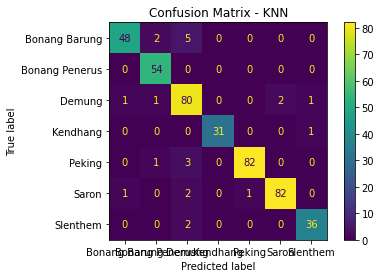

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

knn_mfcc = KNeighborsClassifier(n_neighbors=5) 

knn_mfcc.fit(X_train, y_train)

y_val_pred = knn_mfcc.predict(X_val)
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))

y_test_pred = knn_mfcc.predict(X_test)
print("Testing Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

conf_matrix = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=le.classes_)
disp.plot(cmap='viridis')
plt.title("Confusion Matrix - KNN")
plt.show()


## FFT

In [30]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

def reduce_noise(audio, sr, threshold=0.02):
    stft = librosa.stft(audio)
    spectrogram = np.abs(stft)
    spectrogram[spectrogram < threshold] = 0
    filtered_stft = stft * (spectrogram > 0)
    denoised_audio = librosa.istft(filtered_stft)

    return denoised_audio

def extract_fft_features_with_noise_reduction(folder_path, duration=5, sr=16000, noise_threshold=0.02):
    data = []
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):
            for file in os.listdir(label_path):
                if file.endswith(".wav"):
                    file_path = os.path.join(label_path, file)
                    try:
                        audio, _ = librosa.load(file_path, sr=sr, duration=duration)
                        audio_clean = reduce_noise(audio, sr, threshold=noise_threshold)
                        fft = np.fft.fft(audio_clean)
                        magnitude = np.abs(fft)  
                        magnitude_mean = np.mean(magnitude)  
                        magnitude_std = np.std(magnitude)   
                        features = np.array([magnitude_mean, magnitude_std])
                        data.append({"FFT": features, "Label": label})
                    except Exception as e:
                        print(f"Error processing {file_path}: {e}")
    return pd.DataFrame(data)

main_folder = os.path.join(os.getcwd(), "dataset_fiks") 

df_fft = extract_fft_features_with_noise_reduction(main_folder)

# Encode label menjadi angka
le = LabelEncoder()
df_fft['EncodedLabel'] = le.fit_transform(df_fft['Label'])

# Split data menjadi fitur (X) dan label (y)
X_fft = np.array([fft.flatten() for fft in df_fft['FFT']])  
y_fft = np.array(df_fft['EncodedLabel'])


X_train_fft, X_temp_fft, y_train_fft, y_temp_fft = train_test_split(X_fft, y_fft, test_size=0.3, random_state=42, stratify=y_fft)
X_val_fft, X_test_fft, y_val_fft, y_test_fft = train_test_split(X_temp_fft, y_temp_fft, test_size=0.5, random_state=42, stratify=y_temp_fft)

print("FFT DataFrame with Noise Reduction:")
print(df_fft.head())


FFT DataFrame with Noise Reduction:
                                        FFT          Label  EncodedLabel
0  [0.3167868662272842, 1.6911109609360093]  Bonang Barung             0
1  [0.5385411768908633, 4.6888789614373705]  Bonang Barung             0
2   [0.4859670424516065, 2.992733899202981]  Bonang Barung             0
3  [0.34410625778403897, 1.864337356764709]  Bonang Barung             0
4   [0.582758102858076, 3.7840200272529714]  Bonang Barung             0


### FFT dengan KNN

Validation Classification Report for FFT:
                precision    recall  f1-score   support

 Bonang Barung       0.56      0.67      0.61        54
Bonang Penerus       0.77      0.93      0.84        55
        Demung       0.61      0.69      0.65        85
      Kendhang       0.77      0.61      0.68        33
        Peking       0.82      0.69      0.75        85
         Saron       0.78      0.74      0.76        85
      Slenthem       0.83      0.63      0.72        38

      accuracy                           0.72       435
     macro avg       0.73      0.71      0.72       435
  weighted avg       0.73      0.72      0.72       435

Testing Classification Report for FFT:
                precision    recall  f1-score   support

 Bonang Barung       0.53      0.51      0.52        55
Bonang Penerus       0.71      0.83      0.77        54
        Demung       0.60      0.68      0.64        85
      Kendhang       0.86      0.59      0.70        32
        Peking     

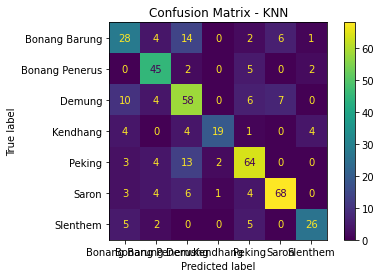

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

knn_fft = KNeighborsClassifier(n_neighbors=5)  

knn_fft.fit(X_train_fft, y_train_fft)

y_val_pred_fft = knn_fft.predict(X_val_fft)
print("Validation Classification Report for FFT:")
print(classification_report(y_val_fft, y_val_pred_fft, target_names=le.classes_))

y_test_pred_fft = knn_fft.predict(X_test_fft)
print("Testing Classification Report for FFT:")
print(classification_report(y_test_fft, y_test_pred_fft, target_names=le.classes_))

conf_matrix = confusion_matrix(y_test_fft, y_test_pred_fft)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=le.classes_)
disp.plot(cmap='viridis')
plt.title("Confusion Matrix - KNN")
plt.show()


## STFT

In [11]:
import numpy as np
import librosa
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def extract_stft_with_noise_reduction(folder_path, duration=5, sr=16000, noise_threshold=0.02):
    data = []
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):
            for file in os.listdir(label_path):
                if file.endswith(".wav"):
                    file_path = os.path.join(label_path, file)
                    try:
                        audio, _ = librosa.load(file_path, sr=sr, duration=duration)
                        audio = reduce_noise(audio, sr, threshold=noise_threshold)
                        stft = librosa.stft(audio)
                        stft_abs = np.abs(stft)  
                        stft_mean = np.mean(stft_abs, axis=1)
                        data.append({"STFT": stft_mean, "Label": label})
                    except Exception as e:
                        print(f"Error processing {file_path}: {e}")
    return pd.DataFrame(data)

df_stft = extract_stft_with_noise_reduction(main_folder)

# Encode label menjadi angka
le = LabelEncoder()
df_stft['EncodedLabel'] = le.fit_transform(df_stft['Label'])

# Split data menjadi fitur (X) dan label (y)
X_stft = np.array(df_stft['STFT'].tolist())
y_stft = np.array(df_stft['EncodedLabel'])

X_train_stft, X_temp_stft, y_train_stft, y_temp_stft = train_test_split(X_stft, y_stft, test_size=0.3, random_state=42, stratify=y_stft)
X_val_stft, X_test_stft, y_val_stft, y_test_stft = train_test_split(X_temp_stft, y_temp_stft, test_size=0.5, random_state=42, stratify=y_temp_stft)

X_train_stft_flat = X_train_stft.flatten().reshape(X_train_stft.shape[0], -1)
X_val_stft_flat = X_val_stft.flatten().reshape(X_val_stft.shape[0], -1)
X_test_stft_flat = X_test_stft.flatten().reshape(X_test_stft.shape[0], -1)

y_train_stft = to_categorical(y_train_stft, num_classes=len(le.classes_))
y_val_stft = to_categorical(y_val_stft, num_classes=len(le.classes_))
y_test_stft = to_categorical(y_test_stft, num_classes=len(le.classes_))

y_train_stft = y_train_stft.argmax(axis=1)
y_val_stft = y_val_stft.argmax(axis=1)
y_test_stft = y_test_stft.argmax(axis=1)


### STFT dengan KNN

In [12]:
knn_stft = KNeighborsClassifier(n_neighbors=5)  

knn_stft.fit(X_train_stft_flat, y_train_stft)

y_val_pred_stft = knn_stft.predict(X_val_stft_flat)
print("Validation Classification Report for STFT:")
print(classification_report(y_val_stft, y_val_pred_stft, target_names=le.classes_))

y_test_pred_stft = knn_stft.predict(X_test_stft_flat)
print("Testing Classification Report for STFT:")
print(classification_report(y_test_stft, y_test_pred_stft, target_names=le.classes_))

Validation Classification Report for STFT:
                precision    recall  f1-score   support

 Bonang Barung       0.94      0.94      0.94        54
Bonang Penerus       0.86      0.98      0.92        55
        Demung       0.99      0.93      0.96        85
      Kendhang       0.91      0.94      0.93        33
        Peking       0.97      0.99      0.98        85
         Saron       0.99      0.93      0.96        85
      Slenthem       0.92      0.89      0.91        38

      accuracy                           0.95       435
     macro avg       0.94      0.94      0.94       435
  weighted avg       0.95      0.95      0.95       435

Testing Classification Report for STFT:
                precision    recall  f1-score   support

 Bonang Barung       0.94      0.84      0.88        55
Bonang Penerus       0.79      0.96      0.87        54
        Demung       0.96      0.95      0.96        85
      Kendhang       1.00      0.97      0.98        32
        Peking   

## Spectral Features

In [13]:
import numpy as np
import librosa
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def extract_spectral_features_with_noise_reduction(folder_path, duration=5, sr=16000, noise_threshold=0.02):
    data = []
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):
            for file in os.listdir(label_path):
                if file.endswith(".wav"):
                    file_path = os.path.join(label_path, file)
                    try:
                        audio, _ = librosa.load(file_path, sr=sr, duration=duration)
                        audio = reduce_noise(audio, sr, threshold=noise_threshold)
                        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
                        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)
                        spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
                        zero_crossing_rate = librosa.feature.zero_crossing_rate(y=audio)
                        features = np.hstack([
                            np.mean(spectral_centroid, axis=1),
                            np.mean(spectral_bandwidth, axis=1),
                            np.mean(spectral_contrast, axis=1),
                            np.mean(zero_crossing_rate, axis=1)
                        ])
                        data.append({"SpectralFeatures": features, "Label": label})
                    except Exception as e:
                        print(f"Error processing {file_path}: {e}")
    return pd.DataFrame(data)

df_spectral = extract_spectral_features_with_noise_reduction(main_folder)

# Encode label menjadi angka
le = LabelEncoder()
df_spectral['EncodedLabel'] = le.fit_transform(df_spectral['Label'])

# Split data menjadi fitur (X) dan label (y)
X_spectral = np.array(df_spectral['SpectralFeatures'].tolist())
y_spectral = np.array(df_spectral['EncodedLabel'])

X_train_spectral, X_temp_spectral, y_train_spectral, y_temp_spectral = train_test_split(X_spectral, y_spectral, test_size=0.3, random_state=42, stratify=y_spectral)
X_val_spectral, X_test_spectral, y_val_spectral, y_test_spectral = train_test_split(X_temp_spectral, y_temp_spectral, test_size=0.5, random_state=42, stratify=y_temp_spectral)

X_train_spectral_flat = X_train_spectral.flatten().reshape(X_train_spectral.shape[0], -1)
X_val_spectral_flat = X_val_spectral.flatten().reshape(X_val_spectral.shape[0], -1)
X_test_spectral_flat = X_test_spectral.flatten().reshape(X_test_spectral.shape[0], -1)


Validation Classification Report for Spectral Features:
                precision    recall  f1-score   support

 Bonang Barung       0.77      0.93      0.84        54
Bonang Penerus       0.94      0.82      0.87        55
        Demung       0.91      0.88      0.90        85
      Kendhang       0.83      0.88      0.85        33
        Peking       0.99      0.95      0.97        85
         Saron       0.88      0.89      0.89        85
      Slenthem       0.84      0.82      0.83        38

      accuracy                           0.89       435
     macro avg       0.88      0.88      0.88       435
  weighted avg       0.89      0.89      0.89       435

Testing Classification Report for Spectral Features:
                precision    recall  f1-score   support

 Bonang Barung       0.68      0.87      0.76        55
Bonang Penerus       0.93      0.94      0.94        54
        Demung       0.92      0.89      0.90        85
      Kendhang       0.91      0.91      0.91  

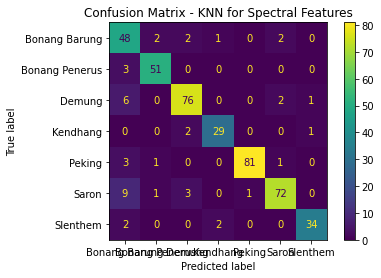

In [14]:
knn_spectral = KNeighborsClassifier(n_neighbors=5)

knn_spectral.fit(X_train_spectral_flat, y_train_spectral)

y_val_pred_spectral = knn_spectral.predict(X_val_spectral_flat)
print("Validation Classification Report for Spectral Features:")
print(classification_report(y_val_spectral, y_val_pred_spectral, target_names=le.classes_))

y_test_pred_spectral = knn_spectral.predict(X_test_spectral_flat)
print("Testing Classification Report for Spectral Features:")
print(classification_report(y_test_spectral, y_test_pred_spectral, target_names=le.classes_))

conf_matrix_spectral = confusion_matrix(y_test_spectral, y_test_pred_spectral)
disp_spectral = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_spectral, display_labels=le.classes_)
disp_spectral.plot(cmap='viridis')
plt.title("Confusion Matrix - KNN for Spectral Features")
plt.show()

# EDA

In [ ]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

def visualize_audio_signals(folder_path, duration=5, sr=16000):
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):
            best_sample = None
            best_energy = -1
            
            for filename in os.listdir(label_path):
                if filename.endswith(".wav"):
                    file_path = os.path.join(label_path, filename)
                    
                    try:
                        audio, _ = librosa.load(file_path, sr=sr, duration=duration)
                        
                        energy = np.sum(audio**2)

                        if energy > best_energy:
                            best_energy = energy
                            best_sample = file_path
                    except Exception as e:
                        print(f"Error processing {file_path}: {e}")
            
            if best_sample:
                audio, _ = librosa.load(best_sample, sr=sr, duration=duration)

                fig, axes = plt.subplots(1, 3, figsize=(20, 5))
                fig.suptitle(f'Audio Signal Analysis for {label}', fontsize=16)

                axes[0].set_title(f'Waveform - {os.path.basename(best_sample)}')
                librosa.display.waveshow(audio, sr=sr, ax=axes[0])
                axes[0].set_xlabel('Time')
                axes[0].set_ylabel('Amplitude')
                
                spectrum = np.abs(np.fft.fft(audio))
                freqs = np.fft.fftfreq(len(audio), 1/sr)
                
                positive_freq_idxs = np.where(freqs >= 0)
                axes[1].set_title(f'Spectrum - {os.path.basename(best_sample)}')
                axes[1].plot(freqs[positive_freq_idxs], spectrum[positive_freq_idxs])
                axes[1].set_xlabel('Frequency (Hz)')
                axes[1].set_ylabel('Magnitude')
                axes[1].set_xlim(0, sr/2)  # Nyquist frequency

                axes[2].set_title(f'Spectrogram - {os.path.basename(best_sample)}')
                D = librosa.stft(audio)
                DB = librosa.amplitude_to_db(np.abs(D), ref=np.max)
                img = librosa.display.specshow(DB, sr=sr, x_axis='time', 
                                               y_axis='hz', ax=axes[2])
                fig.colorbar(img, ax=axes[2], format="%+2.0f dB")
                
                plt.tight_layout()
                plt.show()


visualize_audio_signals(main_folder)


# Model Terbaik
## CNN 1D

In [8]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

X_train_nn, X_val_nn, X_test_nn = X_train, X_val, X_test
y_train_nn, y_val_cnn, y_test_nn = y_train, y_val, y_test

y_train_nn = to_categorical(y_train_nn, num_classes=len(le.classes_))
y_val_cnn = to_categorical(y_val_cnn, num_classes=len(le.classes_))
y_test_nn = to_categorical(y_test_nn, num_classes=len(le.classes_))

X_train_nn = X_train_nn[..., np.newaxis]
X_val_nn = X_val_nn[..., np.newaxis]
X_test_cnn = X_test_nn[..., np.newaxis]


cnn1d_model = Sequential([
    Input(shape=(X_train_nn.shape[1], X_train_nn.shape[2])),  
    Conv1D(32, kernel_size=2, activation='relu'),              
    MaxPooling1D(pool_size=2),                                  
    Dropout(0.2),

    Conv1D(64, kernel_size=2, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(le.classes_), activation='softmax')               
])


cnn1d_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

cnn1d_model.summary()

cnn1d_model.fit(X_train_nn, y_train_nn, epochs=10, batch_size=32, validation_data=(X_val_nn, y_val_cnn))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 12, 32)         │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 6, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 5, 64)          │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,671 (84.65 KB)

 Trainable params: 21,671 (84.65 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.1935 - loss: 28.5837 - val_accuracy: 0.6414 - val_loss: 1.0762
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4187 - loss: 4.0886 - val_accuracy: 0.8230 - val_loss: 0.5637
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5580 - loss: 2.0258 - val_accuracy: 0.8368 - val_loss: 0.4989
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6655 - loss: 1.1699 - val_accuracy: 0.8437 - val_loss: 0.4215
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7434 - loss: 0.9057 - val_accuracy: 0.8644 - val_loss: 0.3950
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7408 - loss: 0.8401 - val_accuracy: 0.8782 - val_loss: 0.3483
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7632 - loss: 0.7251 - val_accuracy: 0.8575 - val_loss: 0.3203
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7898 - loss: 0.7044 - val_accuracy: 0.8828 - val_los

In [9]:
print("Shape of X_train:", X_train.shape)


Shape of X_train: (2031, 13)


In [10]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',    
    patience=5,            
    restore_best_weights=True  
)

history = cnn1d_model.fit(
    X_train_nn, y_train_nn,
    validation_data=(X_val_nn, y_val_cnn),
    epochs=100,          
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]  
)


Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8059 - loss: 0.5349 - val_accuracy: 0.8828 - val_loss: 0.2485
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8484 - loss: 0.4765 - val_accuracy: 0.8828 - val_loss: 0.2515
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8268 - loss: 0.5048 - val_accuracy: 0.8828 - val_loss: 0.2436
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8482 - loss: 0.4106 - val_accuracy: 0.8989 - val_loss: 0.2231
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8749 - loss: 0.3748 - val_accuracy: 0.9034 - val_loss: 0.2193
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8554 - loss: 0.4074 - val_accuracy: 0.9057 - val_loss: 0.2118
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8580 - loss: 0.4095 - val_accuracy: 0.9057 - val_loss: 0.2078
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8718 - loss: 0.3566 - val_accuracy: 0.9103 - v

In [11]:
test_loss, test_accuracy = cnn1d_model.evaluate(X_test_cnn, y_test_nn, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9744 - loss: 0.0684 
Test Loss: 0.1072
Test Accuracy: 0.9587


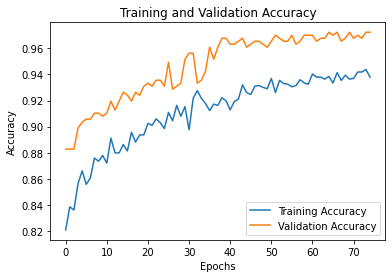

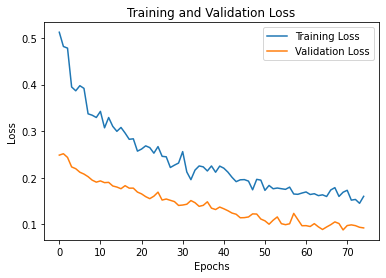

In [12]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Classification Report:
                precision    recall  f1-score   support

 Bonang Barung       1.00      0.91      0.95        55
Bonang Penerus       0.85      0.98      0.91        54
        Demung       0.98      0.95      0.96        85
      Kendhang       0.97      0.97      0.97        32
        Peking       1.00      0.97      0.98        86
         Saron       0.95      0.98      0.97        86
      Slenthem       0.95      0.95      0.95        38

      accuracy                           0.96       436
     macro avg       0.96      0.96      0.96       436
  weighted avg       0.96      0.96      0.96       436



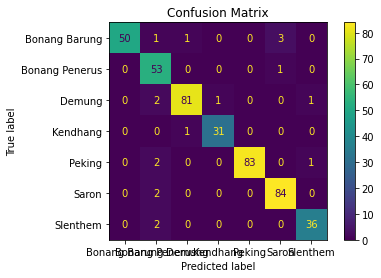

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_test_pred = cnn1d_model.predict(X_test_nn)
y_test_pred_classes = y_test_pred.argmax(axis=1)  
y_test_true_classes = y_test_nn.argmax(axis=1)      

# Tampilkan laporan klasifikasi
print("Classification Report:")
print(classification_report(y_test_true_classes, y_test_pred_classes, target_names=le.classes_))

conf_matrix = confusion_matrix(y_test_true_classes, y_test_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=le.classes_)
disp.plot(cmap='viridis')
plt.title("Confusion Matrix")
plt.show()


## SVM

In [14]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [15]:
svm_model = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)

svm_model.fit(X_train, y_train)


SVC(C=1, random_state=42)

Validation Classification Report:
                precision    recall  f1-score   support

 Bonang Barung       1.00      0.93      0.96        54
Bonang Penerus       0.98      0.93      0.95        55
        Demung       0.96      0.82      0.89        85
      Kendhang       0.72      0.55      0.62        33
        Peking       0.89      0.96      0.93        85
         Saron       0.87      0.95      0.91        85
      Slenthem       0.74      0.97      0.84        38

      accuracy                           0.89       435
     macro avg       0.88      0.87      0.87       435
  weighted avg       0.90      0.89      0.89       435

Testing Classification Report:
                precision    recall  f1-score   support

 Bonang Barung       1.00      0.82      0.90        55
Bonang Penerus       0.96      0.96      0.96        54
        Demung       0.99      0.92      0.95        85
      Kendhang       0.86      0.56      0.68        32
        Peking       0.90      0.97

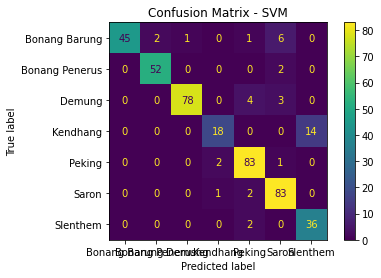

In [16]:
y_val_pred = svm_model.predict(X_val)
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))

y_test_pred = svm_model.predict(X_test)
print("Testing Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

conf_matrix = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=le.classes_)
disp.plot(cmap='viridis')
plt.title("Confusion Matrix - SVM")
plt.show()


## Multilayer Perceptron (MLP)

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

mlp_model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_nn.shape[1],)),  
    Dropout(0.3),  
    Dense(128, activation='relu'),  
    Dropout(0.3),
    Dense(64, activation='relu'),  
    Dropout(0.3),
    Dense(len(le.classes_), activation='softmax')  
])

mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

mlp_model.summary()


c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 256)            │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,191 (176.53 KB)

 Trainable params: 45,191 (176.53 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_mlp = mlp_model.fit(
    X_train_nn, y_train_nn,
    validation_data=(X_val_nn, y_val_cnn),
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)


Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.1909 - loss: 25.0612 - val_accuracy: 0.3172 - val_loss: 1.9137
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1960 - loss: 4.8574 - val_accuracy: 0.1954 - val_loss: 1.9388
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2029 - loss: 2.6290 - val_accuracy: 0.1954 - val_loss: 1.9309
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2198 - loss: 2.2469 - val_accuracy: 0.1954 - val_loss: 1.9234
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2069 - loss: 2.1619 - val_accuracy: 0.1954 - val_loss: 1.9163
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2245 - loss: 2.0012 - val_accuracy: 0.1954 - val_loss: 1.9103
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2322 - loss: 2.0161 - val_accuracy: 0.2138 - val_loss: 1.9030
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2639 - loss: 1.8935 - val_accuracy: 0.3793 - 

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9442 - loss: 0.1139 
Test Loss: 0.1396
Test Accuracy: 0.9404
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Classification Report:
                precision    recall  f1-score   support

 Bonang Barung       1.00      0.82      0.90        55
Bonang Penerus       0.95      0.96      0.95        54
        Demung       0.83      1.00      0.90        85
      Kendhang       1.00      0.94      0.97        32
        Peking       1.00      0.95      0.98        86
         Saron       0.98      0.93      0.95        86
      Slenthem       0.92      0.95      0.94        38

      accuracy                           0.94       436
     macro avg       0.95      0.94      0.94       436
  weighted avg       0.95      0.94      0.94       436



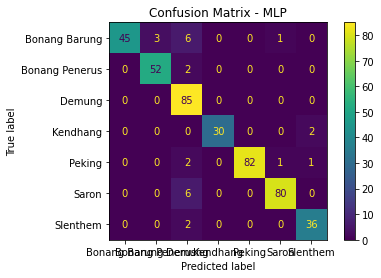

In [19]:
test_loss, test_accuracy = mlp_model.evaluate(X_test_cnn, y_test_nn, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

y_test_pred = mlp_model.predict(X_test_cnn)
y_test_pred_classes = y_test_pred.argmax(axis=1)
y_test_true_classes = y_test_nn.argmax(axis=1)

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
print("\nClassification Report:")
print(classification_report(y_test_true_classes, y_test_pred_classes, target_names=le.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_true_classes, y_test_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=le.classes_)
disp.plot(cmap='viridis')
plt.title("Confusion Matrix - MLP")
plt.show()


## RANDOM FOREST

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

Validation Classification Report:
                precision    recall  f1-score   support

 Bonang Barung       0.98      0.94      0.96        54
Bonang Penerus       0.89      0.98      0.93        55
        Demung       1.00      0.94      0.97        85
      Kendhang       0.94      1.00      0.97        33
        Peking       0.99      0.99      0.99        85
         Saron       0.96      0.96      0.96        85
      Slenthem       1.00      0.97      0.99        38

      accuracy                           0.97       435
     macro avg       0.97      0.97      0.97       435
  weighted avg       0.97      0.97      0.97       435

Testing Classification Report:
                precision    recall  f1-score   support

 Bonang Barung       1.00      0.89      0.94        55
Bonang Penerus       0.83      1.00      0.91        54
        Demung       0.98      0.95      0.96        85
      Kendhang       0.97      1.00      0.98        32
        Peking       1.00      0.98

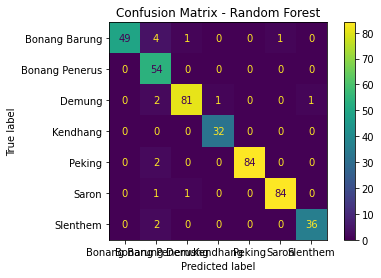

In [21]:
y_val_pred = rf_model.predict(X_val)
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))

y_test_pred = rf_model.predict(X_test)
print("Testing Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

conf_matrix = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=le.classes_)
disp.plot(cmap='viridis')
plt.title("Confusion Matrix - Random Forest")
plt.show()


## KNN

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

knn_model = KNeighborsClassifier(n_neighbors=5)  

knn_model.fit(X_train, y_train)


KNeighborsClassifier()

Validation Classification Report:
                precision    recall  f1-score   support

 Bonang Barung       1.00      0.93      0.96        54
Bonang Penerus       0.96      0.95      0.95        55
        Demung       0.89      0.92      0.90        85
      Kendhang       0.84      0.94      0.89        33
        Peking       0.99      0.99      0.99        85
         Saron       0.95      0.95      0.95        85
      Slenthem       0.94      0.89      0.92        38

      accuracy                           0.94       435
     macro avg       0.94      0.94      0.94       435
  weighted avg       0.94      0.94      0.94       435

Testing Classification Report:
                precision    recall  f1-score   support

 Bonang Barung       0.96      0.87      0.91        55
Bonang Penerus       0.93      1.00      0.96        54
        Demung       0.87      0.94      0.90        85
      Kendhang       1.00      0.97      0.98        32
        Peking       0.99      0.95

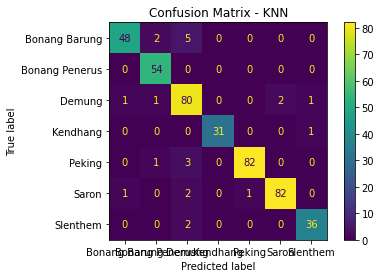

In [23]:
y_val_pred = knn_model.predict(X_val)
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))

y_test_pred = knn_model.predict(X_test)
print("Testing Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

conf_matrix = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=le.classes_)
disp.plot(cmap='viridis')
plt.title("Confusion Matrix - KNN")
plt.show()


## XGBoost

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:49:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Testing Classification Report:
                precision    recall  f1-score   support

 Bonang Barung       1.00      0.82      0.90        55
Bonang Penerus       0.77      0.98      0.86        54
        Demung       0.98      0.95      0.96        85
      Kendhang       0.94      1.00      0.97        32
        Peking       1.00      0.97      0.98        86
         Saron       0.99      0.98      0.98        86
      Slenthem       0.97      0.95      0.96        38

      accuracy                           0.95       436
     macro avg       0.95      0.95      0.95       436
  weighted avg       0.96      0.95      0.95       436



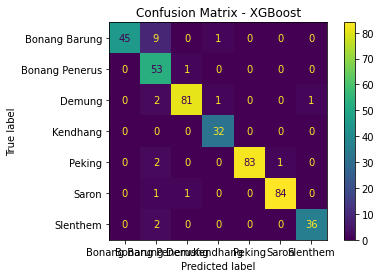

In [24]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, use_label_encoder=False)

xgb_model.fit(X_train, y_train)
y_test_pred = xgb_model.predict(X_test)

print("Testing Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

conf_matrix = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=le.classes_)
disp.plot(cmap='viridis')
plt.title("Confusion Matrix - XGBoost")
plt.show()


## RNN

In [25]:
print("Shape of X_train:", X_train.shape)  
print("Shape of X_val:", X_val.shape)
print("Shape of X_test:", X_test.shape)

y_train_rnn = y_train_nn  
y_val_rnn = y_val_cnn
y_test_rnn = y_test_nn


Shape of X_train: (2031, 13)
Shape of X_val: (435, 13)
Shape of X_test: (436, 13)


In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

rnn_model = Sequential([
    SimpleRNN(128, activation='relu', input_shape=(X_train_nn.shape[1], X_train_nn.shape[2]), return_sequences=True),
    Dropout(0.2),
    SimpleRNN(64, activation='relu', return_sequences=False),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(le.classes_), activation='softmax')  
])

rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

rnn_model.summary()

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 13, 128)        │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 13, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,215 (149.28 KB)

 Trainable params: 38,215 (149.28 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_rnn = rnn_model.fit(
    X_train_nn, y_train_rnn,
    validation_data=(X_val_nn, y_val_rnn),
    epochs=30,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)


Epoch 1/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.2756 - loss: 3.8264 - val_accuracy: 0.5885 - val_loss: 1.1357
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5450 - loss: 1.2143 - val_accuracy: 0.7448 - val_loss: 0.7151
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6800 - loss: 0.8437 - val_accuracy: 0.8437 - val_loss: 0.4918
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7743 - loss: 0.6363 - val_accuracy: 0.8736 - val_loss: 0.2891
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8513 - loss: 0.4197 - val_accuracy: 0.9195 - val_loss: 0.2253
Epoch 6/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8482 - loss: 0.4359 - val_accuracy: 0.9172 - val_loss: 0.1774
Epoch 7/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9084 - loss: 0.3021 - val_accuracy: 0.9448 - val_loss: 0.1476
Epoch 8/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9004 - loss: 0.2974 - val_accuracy: 0.9425 - val

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9553 - loss: 0.0919 
Test Loss: 0.1241
Test Accuracy: 0.9450
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step

Classification Report:
                precision    recall  f1-score   support

 Bonang Barung       0.96      0.87      0.91        55
Bonang Penerus       0.77      1.00      0.87        54
        Demung       0.96      0.95      0.96        85
      Kendhang       1.00      1.00      1.00        32
        Peking       1.00      0.94      0.97        86
         Saron       0.96      0.93      0.95        86
      Slenthem       1.00      0.95      0.97        38

      accuracy                           0.94       436
     macro avg       0.95      0.95      0.95       436
  weighted avg       0.95      0.94      0.95       436



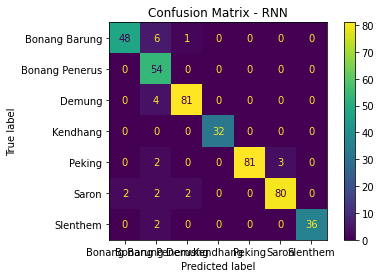

In [28]:
test_loss, test_accuracy = rnn_model.evaluate(X_test_cnn, y_test_rnn, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

y_test_pred = rnn_model.predict(X_test_cnn)
y_test_pred_classes = y_test_pred.argmax(axis=1)
y_test_true_classes = y_test_rnn.argmax(axis=1)

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
print("\nClassification Report:")
print(classification_report(y_test_true_classes, y_test_pred_classes, target_names=le.classes_))

conf_matrix = confusion_matrix(y_test_true_classes, y_test_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=le.classes_)
disp.plot(cmap='viridis')
plt.title("Confusion Matrix - RNN")
plt.show()


## LSTM

In [29]:
print("Shape of X_train:", X_train.shape)  
print("Shape of X_val:", X_val.shape)
print("Shape of X_test:", X_test.shape)

y_train_lstm = y_train_nn 
y_val_lstm = y_val_cnn
y_test_lstm = y_test_nn


Shape of X_train: (2031, 13)
Shape of X_val: (435, 13)
Shape of X_test: (436, 13)


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

lstm_model = Sequential([
    LSTM(128, activation='tanh', input_shape=(X_train_nn.shape[1], X_train_nn.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(64, activation='tanh', return_sequences=False),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(le.classes_), activation='softmax')  
])

lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

lstm_model.summary()


c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 13, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 13, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,191 (489.03 KB)

 Trainable params: 125,191 (489.03 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_lstm = lstm_model.fit(
    X_train_nn, y_train_lstm,
    validation_data=(X_val_nn, y_val_lstm),
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)


Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5285 - loss: 1.3542 - val_accuracy: 0.8690 - val_loss: 0.3552
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8694 - loss: 0.3733 - val_accuracy: 0.9218 - val_loss: 0.2230
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9189 - loss: 0.2598 - val_accuracy: 0.8989 - val_loss: 0.2654
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9142 - loss: 0.2501 - val_accuracy: 0.9264 - val_loss: 0.1872
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9347 - loss: 0.1890 - val_accuracy: 0.9241 - val_loss: 0.1694
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9467 - loss: 0.1691 - val_accuracy: 0.9103 - val_loss: 0.2239
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9323 - loss: 0.1885 - val_accuracy: 0.9517 - val_loss: 0.1437
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9411 - loss: 0.1530 - val_accuracy: 0.

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9775 - loss: 0.0601 
Test Loss: 0.0998
Test Accuracy: 0.9633
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Classification Report:
                precision    recall  f1-score   support

 Bonang Barung       1.00      0.91      0.95        55
Bonang Penerus       0.83      1.00      0.91        54
        Demung       0.98      0.95      0.96        85
      Kendhang       1.00      0.97      0.98        32
        Peking       0.99      0.98      0.98        86
         Saron       1.00      0.98      0.99        86
      Slenthem       0.95      0.95      0.95        38

      accuracy                           0.96       436
     macro avg       0.96      0.96      0.96       436
  weighted avg       0.97      0.96      0.96       436



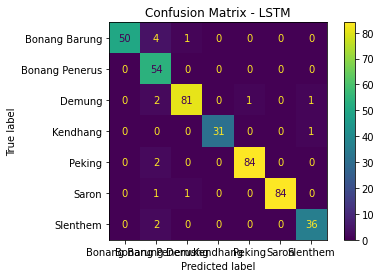

In [55]:
test_loss, test_accuracy = lstm_model.evaluate(X_test_cnn, y_test_lstm, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

y_test_pred = lstm_model.predict(X_test_cnn)
y_test_pred_classes = y_test_pred.argmax(axis=1)
y_test_true_classes = y_test_lstm.argmax(axis=1)

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
print("\nClassification Report:")
print(classification_report(y_test_true_classes, y_test_pred_classes, target_names=le.classes_))

conf_matrix = confusion_matrix(y_test_true_classes, y_test_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=le.classes_)
disp.plot(cmap='viridis')
plt.title("Confusion Matrix - LSTM")
plt.show()


## CNN + LSTM

In [32]:
print("Shape of X_train:", X_train.shape) 
print("Shape of X_val:", X_val.shape)
print("Shape of X_test:", X_test.shape)

y_train_cnn_lstm = y_train_nn 
y_val_cnn_lstm = y_val_cnn
y_test_cnn_lstm = y_test_nn


Shape of X_train: (2031, 13)
Shape of X_val: (435, 13)
Shape of X_test: (436, 13)


In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, TimeDistributed, Flatten

cnn_lstm_model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_nn.shape[1], X_train_nn.shape[2])),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    LSTM(128, activation='tanh', return_sequences=True),
    Dropout(0.3),
    LSTM(64, activation='tanh', return_sequences=False),
    Dropout(0.3),

    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(le.classes_), activation='softmax')  
])

cnn_lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

cnn_lstm_model.summary()


c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 11, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 3, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 215,175 (840.53 KB)

 Trainable params: 215,175 (840.53 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_cnn_lstm = cnn_lstm_model.fit(
    X_train_nn, y_train_cnn_lstm,
    validation_data=(X_val_nn, y_val_cnn_lstm),
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)


Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.1836 - loss: 1.9212 - val_accuracy: 0.2092 - val_loss: 1.7335
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3061 - loss: 1.6907 - val_accuracy: 0.5816 - val_loss: 0.9585
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6129 - loss: 1.0264 - val_accuracy: 0.7770 - val_loss: 0.5417
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7288 - loss: 0.7222 - val_accuracy: 0.8782 - val_loss: 0.3649
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8313 - loss: 0.5016 - val_accuracy: 0.9080 - val_loss: 0.2812
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8669 - loss: 0.3995 - val_accuracy: 0.9080 - val_loss: 0.2225
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8835 - loss: 0.3604 - val_accuracy: 0.9172 - val_loss: 0.2264
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8857 - loss: 0.3454 - val_accuracy: 0.

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9675 - loss: 0.0672 
Test Loss: 0.1076
Test Accuracy: 0.9518
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

Classification Report:
                precision    recall  f1-score   support

 Bonang Barung       1.00      0.87      0.93        55
Bonang Penerus       0.81      1.00      0.89        54
        Demung       0.94      0.95      0.95        85
      Kendhang       1.00      1.00      1.00        32
        Peking       1.00      0.98      0.99        86
         Saron       0.98      0.93      0.95        86
      Slenthem       0.97      0.95      0.96        38

      accuracy                           0.95       436
     macro avg       0.96      0.95      0.95       436
  weighted avg       0.96      0.95      0.95       436



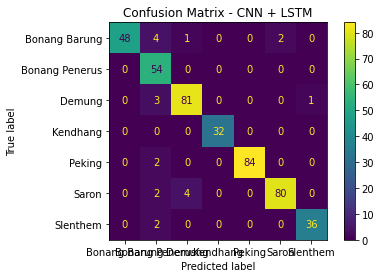

In [35]:
test_loss, test_accuracy = cnn_lstm_model.evaluate(X_test_cnn, y_test_cnn_lstm, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

y_test_pred = cnn_lstm_model.predict(X_test_cnn)
y_test_pred_classes = y_test_pred.argmax(axis=1)
y_test_true_classes = y_test_cnn_lstm.argmax(axis=1)

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
print("\nClassification Report:")
print(classification_report(y_test_true_classes, y_test_pred_classes, target_names=le.classes_))

conf_matrix = confusion_matrix(y_test_true_classes, y_test_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=le.classes_)
disp.plot(cmap='viridis')
plt.title("Confusion Matrix - CNN + LSTM")
plt.show()


## Naive Bayes

In [36]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

nb_model = GaussianNB()

nb_model.fit(X_train, y_train)


GaussianNB()

Validation Classification Report:
                precision    recall  f1-score   support

 Bonang Barung       0.78      0.93      0.85        54
Bonang Penerus       0.97      0.67      0.80        55
        Demung       0.96      0.85      0.90        85
      Kendhang       0.70      1.00      0.82        33
        Peking       1.00      0.96      0.98        85
         Saron       0.88      0.95      0.92        85
      Slenthem       1.00      0.97      0.99        38

      accuracy                           0.90       435
     macro avg       0.90      0.91      0.89       435
  weighted avg       0.92      0.90      0.90       435

Testing Classification Report:
                precision    recall  f1-score   support

 Bonang Barung       0.87      0.84      0.85        55
Bonang Penerus       0.96      0.83      0.89        54
        Demung       0.99      0.91      0.94        85
      Kendhang       0.66      0.97      0.78        32
        Peking       1.00      0.94

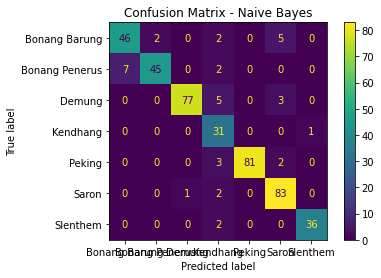

In [37]:
y_val_pred = nb_model.predict(X_val)
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))

y_test_pred = nb_model.predict(X_test)
print("Testing Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

conf_matrix = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=le.classes_)
disp.plot(cmap='viridis')
plt.title("Confusion Matrix - Naive Bayes")
plt.show()


# Analisis Kesalahan

In [38]:
def analyze_misclassifications(y_true, y_pred, label_encoder, model_name="Model"):
    """
    Fungsi untuk menganalisis salah prediksi pada data.
    Args:
        y_true (np.array): True labels dalam format integer.
        y_pred (np.array): Predicted labels dalam format integer.
        label_encoder (LabelEncoder): Encoder untuk mengonversi integer ke label string.
        model_name (str): Nama model untuk output.
    """
    true_labels = label_encoder.inverse_transform(y_true)
    predicted_labels = label_encoder.inverse_transform(y_pred)

    misclassifications = []

    for idx, (true, pred) in enumerate(zip(true_labels, predicted_labels)):
        if true != pred:
            misclassifications.append({"Index": idx, "True Label": true, "Predicted Label": pred})

    total_misclassified = len(misclassifications)

    print(f"\n{model_name} - Total Misclassifications: {total_misclassified}")
    for misclass in misclassifications:
        print(f"Index: {misclass['Index']}, True Label: {misclass['True Label']}, Predicted Label: {misclass['Predicted Label']}")

    return misclassifications


for model_name, predictions in {
    "LSTM": lstm_model.predict(X_test_cnn).argmax(axis=1),
    "Random Forest" : rf_model.predict(X_test)
}.items():
    misclassified = analyze_misclassifications(
        y_test_lstm.argmax(axis=1),
        predictions,
        le,
        model_name
    )


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step

LSTM - Total Misclassifications: 14
Index: 63, True Label: Saron, Predicted Label: Peking
Index: 73, True Label: Bonang Barung, Predicted Label: Bonang Penerus
Index: 110, True Label: Bonang Barung, Predicted Label: Bonang Penerus
Index: 121, True Label: Demung, Predicted Label: Saron
Index: 152, True Label: Bonang Barung, Predicted Label: Bonang Penerus
Index: 180, True Label: Demung, Predicted Label: Peking
Index: 278, True Label: Bonang Barung, Predicted Label: Peking
Index: 301, True Label: Saron, Predicted Label: Peking
Index: 313, True Label: Demung, Predicted Label: Peking
Index: 360, True Label: Bonang Barung, Predicted Label: Demung
Index: 399, True Label: Slenthem, Predicted Label: Peking
Index: 406, True Label: Demung, Predicted Label: Slenthem
Index: 426, True Label: Slenthem, Predicted Label: Peking
Index: 427, True Label: Demung, Predicted Label: Slenthem

Random Forest - Total Misclassifications: 16
Index: 63, True Label: Saron, P